In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
N_JOBS = 15 # cpu_count()
os.environ['MKL_NUM_THREADS'] = str(N_JOBS)
os.environ['OMP_NUM_THREADS'] = str(N_JOBS)

IMG_SIZE = 640
BATCH_SIZE = 2
TAG = f'{IMG_SIZE}_stage2'

In [2]:
import numpy as np
import pandas as pd
import gc
import keras

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split,StratifiedKFold

# from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply
from keras.utils.training_utils import multi_gpu_model


from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import glob
import shutil
import os
import random
from PIL import Image
import pandas as pd
from sklearn.model_selection import StratifiedKFold

seed = 111
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.set_random_seed(seed)
    
%matplotlib inline

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

DATA_DIR = '/mnt/ssd1/kaggle/pneumothorax/data'
CHECKPOINT_DIR = '/mnt/ssd1/kaggle/pneumothorax/checkpoints'

Using TensorFlow backend.
/home/n01z3/anaconda3/envs/wz/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/n01z3/anaconda3/envs/wz/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/n01z3/anaconda3/envs/wz/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/n01z3/anaconda3/envs/wz/lib/p

In [3]:
import pickle
def write_pickle_obj(obj, name=None):
    if name is not None:
        with open(name, 'wb') as file:
            pickle.dump(obj, file, pickle.HIGHEST_PROTOCOL)
            
import pickle
def read_pickle_obj(name=None):
    if name is not None:
        with open(name, 'rb') as file:
            return pickle.load(file)

In [4]:
masks_bool = read_pickle_obj('masks_bool.pickle')

# train_im_path,train_mask_path = f'{DATA_DIR}/keras_im_train_full',f'{DATA_DIR}/keras_mask_train_full'
train_im_path,train_mask_path = f'{DATA_DIR}/keras_im_train',f'{DATA_DIR}/keras_mask_train'
h, w, batch_size = IMG_SIZE, IMG_SIZE, BATCH_SIZE

val_im_path,val_mask_path = f'{DATA_DIR}/keras_im_val',f'{DATA_DIR}/keras_mask_val'

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, train_im_path=train_im_path,train_mask_path=train_mask_path,
                 augmentations=None, batch_size=batch_size,
                 img_size=h, n_channels=3, shuffle=True, debug=False, stratified=False):
        'Initialization'
        self.batch_size = batch_size
        if debug:
            self.train_im_paths = glob.glob(train_im_path+'/*')[:50]
        else:
            self.train_im_paths = glob.glob(train_im_path+'/*')
        
        if stratified:
            self.df = pd.DataFrame({'paths': self.train_im_paths, 'masks_bool': masks_bool}, )
            self.make_splits()
        
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path

        self.img_size = img_size
        
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.train_im_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_paths))]

        # Find list of IDs
        list_IDs_im = [self.train_im_paths[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_im)
        
        if self.augment is None:
            return X,np.array(y)/255
        else:            
            im,mask = [],[]   
            for x,y in zip(X,y):
                augmented = self.augment(image=x, mask=y)
                im.append(augmented['image'])
                mask.append(augmented['mask'])
            return np.array(im),np.array(mask)/255

    def make_splits(self):
        
        num_masks = len(self.df[self.df['masks_bool']])
        n_splits=round(len(self.df) / BATCH_SIZE)
        #####
        if n_splits > num_masks:
            self.df = pd.concat([self.df, self.df.loc[np.random.choice(self.df[self.df['masks_bool']].index, size=n_splits-num_masks)]])
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, )
        splits = skf.split(self.df['paths'], self.df['masks_bool'])
        splits = [images for _, images in splits]
        self.train_im_paths = self.df.iloc[np.concatenate(splits)]['paths'].values
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            self.make_splits()
            
        self.indexes = np.arange(len(self.train_im_paths))
        

    def data_generation(self, list_IDs_im):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(list_IDs_im),self.img_size,self.img_size, self.n_channels))
        y = np.empty((len(list_IDs_im),self.img_size,self.img_size, 1))

        # Generate data
        for i, im_path in enumerate(list_IDs_im):
            
            im = np.array(Image.open(im_path))
            mask_path = im_path.replace(self.train_im_path,self.train_mask_path)
            
            mask = np.array(Image.open(mask_path))
            
            
            if len(im.shape)==2:
                im = np.repeat(im[...,None],3,2)

#             # Resize sample
            X[i,] = cv2.resize(im,(self.img_size,self.img_size))

            # Store class
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size))[..., np.newaxis]
            y[y>0] = 255

        return np.uint8(X),np.uint8(y)
    
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

In [5]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint(f"./keras.model_{TAG}",monitor='val_loss', 
                                   mode = 'min', save_best_only=True, verbose=1, save_weights_only=True),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)
    
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.15)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.15)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

from efficientnet.model import EfficientNetB4

def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.15):

    backbone = EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.15)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[154].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.15)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[92].output
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.05)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.05)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.05)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

import numpy as np

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [54]:
K.clear_session()
model = UEfficientNet(input_shape=(IMG_SIZE,IMG_SIZE,3), dropout_rate=0.25)
model.load_weights(f'./keras.model_640_v3_stage2')
# model.load_weights(f'./keras.model_640_v3_stage2_pretrained')
# model.load_weights(f'./keras.model_640_v3_ret2_stage2_custom')

# model.load_weights(f'./keras.model_640_stage2_current_best')
# model.load_weights(f'./keras.model_640_v3')


In [55]:
model.compile(loss=bce_dice_loss, optimizer='adam', metrics=[my_iou_metric])

In [56]:
import cv2
from albumentations import (Compose, ToFloat)


AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=1)
],p=1)

In [57]:
def predict_result(model,validation_generator,img_size): 
    # TBD predict both orginal and reflect x
    preds_test1 = model.predict_generator(validation_generator).reshape(-1, img_size, img_size)
    return preds_test1

In [58]:
# valid_im_path,valid_mask_path = f'/mnt/ssd1/kaggle/pneumothorax/data/1024/keras_im_val',\
#                                 f'/mnt/ssd1/kaggle/pneumothorax/data/1024/keras_mask_val'
valid_im_path,valid_mask_path = f'{DATA_DIR}/keras_im_val',f'{DATA_DIR}/keras_mask_val'


validation_generator = DataGenerator(train_im_path=valid_im_path,
                                     train_mask_path=valid_mask_path,
                                     augmentations=AUGMENTATIONS_TEST,
                                     img_size=IMG_SIZE,
                                     shuffle=False)
preds_valid = predict_result(model,
                             validation_generator,
                             IMG_SIZE)

/home/n01z3/anaconda3/envs/wz/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater


In [59]:
# valid_fn = glob.glob(f'/mnt/ssd1/kaggle/pneumothorax/data/1024/keras_mask_val/*')
valid_fn = glob.glob(f'{DATA_DIR}/keras_mask_val/*')
y_valid_ori = np.array([cv2.resize(np.array(Image.open(fn)), (IMG_SIZE,IMG_SIZE)) for fn in valid_fn])
assert y_valid_ori.shape == preds_valid.shape

In [60]:
## Scoring for last model
thresholds = np.linspace(0.4, 0.95, 16)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in thresholds])

In [61]:
# current_best 8215
# v3 827
# v3 stage2 824
# v3 custom 845

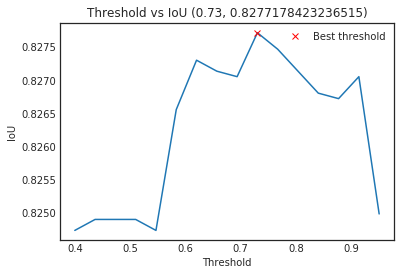

In [62]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [14]:
# max_images = 64
# grid_width = 16
# grid_height = int(max_images / grid_width)
# fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

# validation_generator = DataGenerator(train_im_path=valid_im_path,
#                                      train_mask_path=valid_mask_path,
#                                      augmentations=AUGMENTATIONS_TEST,
#                                      img_size=IMG_SIZE,
#                                      batch_size=64,
#                                      shuffle=False)

# images,masks = validation_generator.__getitem__(0)
# for i,(im, mask) in enumerate(zip(images,masks)):
#     pred = preds_valid[i]
#     ax = axs[int(i / grid_width), i % grid_width]
#     ax.imshow(im[...,0], cmap="bone")
#     ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
#     ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Greens")
#     ax.axis('off')
# plt.suptitle("Green:Prediction , Red: Pneumothorax.")

In [7]:
# threshold_best = 0.9

In [63]:
# test_fn = glob.glob(f'/mnt/ssd1/kaggle/pneumothorax/data/1024/test/*')
test_fn = glob.glob(f'{DATA_DIR}/test/*')
x_test = [cv2.resize(np.array(Image.open(fn)),(IMG_SIZE, IMG_SIZE)) for fn in test_fn]
x_test = np.array(x_test)
x_test = np.array([np.repeat(im[...,None],3,2) for im in x_test])
print(x_test.shape)
preds_test = model.predict(x_test,batch_size=batch_size)
# del x_test; gc.collect()

(3205, 640, 640, 3)


In [15]:
# ids = [o.split('/')[-1][:-4] for o in test_fn]
# sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': -1})
# file_names = sub_df['ImageId']
# n = 0
# for i, (p) in enumerate(preds_test):
#     p = p.squeeze()
#     im = cv2.resize(p,(1024,1024))
#     im = np.uint8(im * 255)
#     im = np.clip(im, 0, 255)
#     if im.max() > 0:
#         n += 1
#     cv2.imwrite(f'./test_st1_masks_new_model_new_test/{file_names[i]}.png', im)
    
# print(n)

# # quit()

709


In [64]:
import pdb

# Generate rle encodings (images are first converted to the original size)
rles = []
i,max_img = 1,10
plt.figure(figsize=(16,4))
for p in preds_test:
    p = p.squeeze()
    im = cv2.resize(p,(1024,1024))
    im = im > threshold_best
#     zero out the smaller regions.
    if im.sum()<1024*2:
        im[:] = 0
    im = (im.T*255).astype(np.uint8)  
    rles.append(mask2rle(im, 1024, 1024))
#     i += 1
#     if i<max_img:
#         plt.subplot(1,max_img,i)
#         plt.imshow(im)
#         plt.axis('off')

<Figure size 1152x288 with 0 Axes>

In [65]:
ids = [o.split('/')[-1][:-4] for o in test_fn]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

ImageId                                      EncodedPixels
0  ID_c43a55a60                                                 -1
1  ID_8279bad58                                                 -1
2  ID_6fd8b6961                                                 -1
3  ID_ed3c71fcc  701588 3 1019 5 1018 7 1017 8 1016 8 1015 9 10...
4  ID_c29352fd2  281883 3 1016 10 1010 14 1009 15 1006 17 1005 ...

In [66]:
sub_df.to_csv(f'keras_submission_{TAG}_best_clear.csv', index=False)

In [18]:
sub_df.tail(10)

ImageId                                      EncodedPixels
3195  ID_114609bb6                                                 -1
3196  ID_632caaffd                                                 -1
3197  ID_d98e1e389                                                 -1
3198  ID_b6790e7e4                                                 -1
3199  ID_cc169bf90                                                 -1
3200  ID_3ca44169d                                                 -1
3201  ID_cac8a5e4a                                                 -1
3202  ID_d7ce2c3e3  214355 2 1 2 2 1 1007 21 1000 24 994 31 990 35...
3203  ID_173cbb58c                                                 -1
3204  ID_c232524de                                                 -1

In [19]:
quit()

In [ ]:
# for blending
test_fn = glob.glob(f'{DATA_DIR}/test/*')
x_test = [cv2.resize(np.array(Image.open(fn)),(IMG_SIZE, IMG_SIZE)) for fn in test_fn]
x_test = np.array(x_test)
x_test = np.array([np.repeat(im[...,None],3,2) for im in x_test])
print(x_test.shape)
preds_test = model.predict(x_test,batch_size=batch_size)
# del x_test; gc.collect()
# write_pickle_obj(preds_test, name='test_640.pickle')

ids = [o.split('/')[-1][:-4] for o in test_fn]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': -1})
file_names = sub_df['ImageId']

for i, (p) in enumerate(preds_test):
    p = p.squeeze()
    im = cv2.resize(p,(1024,1024))
    cv2.imwrite(f'test_masks_sa/{file_names[i]}.png', im)